<a href="https://colab.research.google.com/github/VSable223/vision_guide_ai/blob/main/siglipwithpixle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#   Import libraries and initialize environment

In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt


###   Load dataset and prepare dataloader

In [ ]:

transform = T.Compose([
    T.Resize((224,224)),
    T.ToTensor()
])

dataset = CIFAR10(root="./data", train=True, download=True, transform=transform)

class_names = dataset.classes

def make_caption(label):
    return f"This is an image of a {class_names[label]}"

loader = DataLoader(dataset, batch_size=8, shuffle=True)


100%|██████████| 170M/170M [00:03<00:00, 48.2MB/s]


###   Visualize one sample input image

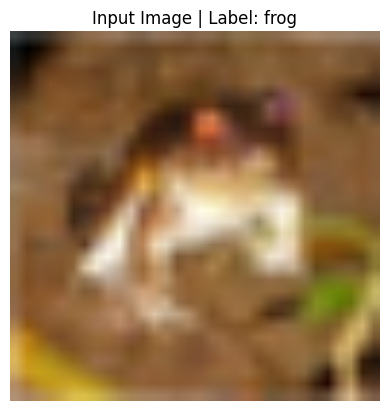

In [ ]:
img, label = dataset[0]
plt.imshow(img.permute(1,2,0))
plt.title(f"Input Image | Label: {dataset.classes[label]}")
plt.axis('off')
plt.show()

###   Convert image into patch tokens (ViT input)

In [ ]:
class PatchEmbed(nn.Module):
    def __init__(self, patch=16, dim=128):
        super().__init__()
        self.proj = nn.Conv2d(3, dim, patch, patch)

    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2).transpose(1, 2)
        return x


patch = PatchEmbed()
patch_tokens = patch(img.unsqueeze(0))
print('Patch Tokens Shape:', patch_tokens.shape)


Patch Tokens Shape: torch.Size([1, 196, 128])


###   Visualize extracted patches

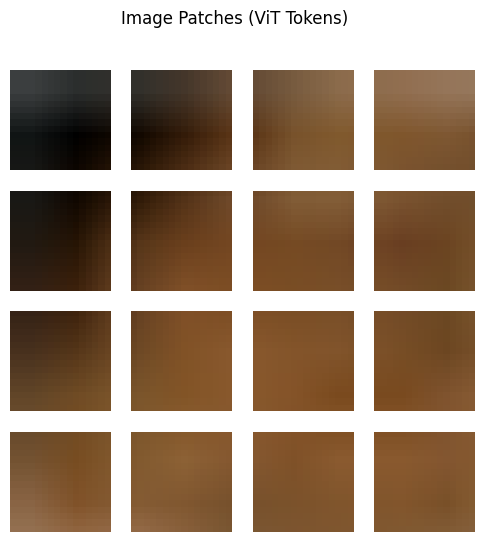

In [ ]:
patch_size = 16
patches = img.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)


fig, ax = plt.subplots(4,4, figsize=(6,6))
for i in range(4):
  for j in range(4):
    ax[i,j].imshow(patches[:,i,j].permute(1,2,0))
    ax[i,j].axis('off')
plt.suptitle('Image Patches (ViT Tokens)')
plt.show()

###   Show positional encoding heatmap

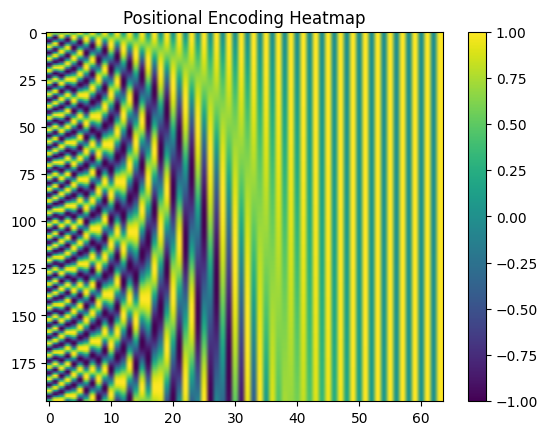

In [ ]:
seq_len = 196
dim = 64
pos = torch.arange(seq_len).unsqueeze(1)
div = torch.exp(torch.arange(0, dim, 2) * (-torch.log(torch.tensor(10000.0)) / dim))

pe = torch.zeros(seq_len, dim)
pe[:,0::2] = torch.sin(pos * div)
pe[:,1::2] = torch.cos(pos * div)

plt.imshow(pe, aspect="auto")
plt.title("Positional Encoding Heatmap")
plt.colorbar()


###   Optional experiment: Pixel Shuffle

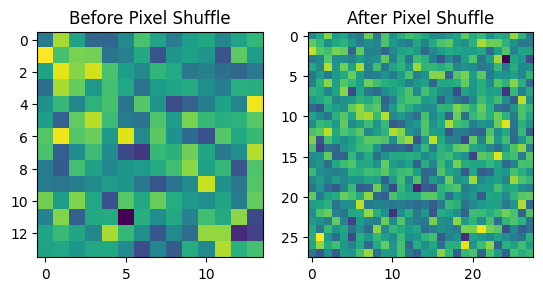

In [ ]:
x = torch.randn(1, 64, 14, 14)
shuffle = nn.PixelShuffle(2)
out = shuffle(x)


plt.subplot(1,2,1)
plt.imshow(x[0,0].detach())
plt.title('Before Pixel Shuffle')


plt.subplot(1,2,2)
plt.imshow(out[0,0].detach())
plt.title('After Pixel Shuffle')
plt.show()

###   Optional experiment: Pixel Refine

In [ ]:

class PixelRefine(nn.Module):
    def __init__(self,upscale=2):
        super().__init__()
        self.shuffle = nn.PixelShuffle(upscale)
    def forward(self, x):
        return self.shuffle(x)


###   Vision Transformer encoder backbone

In [ ]:
class ViTEncoder(nn.Module):
    def __init__(self, patch=16, in_dim=256, proj_dim=128):
        super().__init__()

        # Patch embedding
        self.patch = nn.Conv2d(3, in_dim, patch, patch)

        # Pixel shuffle (upscale = 2 → channels /4, spatial ×2)
        self.pixel_refine = PixelRefine(upscale=2)

        # After pixel shuffle
        self.token_dim = in_dim // 4          # 256 → 64
        self.seq_len = 28 * 28                # 784 tokens (for 224×224 input)

        # Positional embedding
        self.pos = nn.Parameter(
            torch.randn(1, self.seq_len, self.token_dim)
        )

        # Transformer encoder
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=self.token_dim,
                nhead=8,
                dim_feedforward=self.token_dim * 4,
                batch_first=True
            ),
            num_layers=4
        )

        # ✅ Projection head (SigLIP-style)
        self.proj = nn.Linear(self.token_dim, proj_dim)

    def forward(self, x):
        x = self.patch(x)                      # (B, 256, 14, 14)
        x = self.pixel_refine(x)               # (B, 64, 28, 28)
        x = x.flatten(2).transpose(1, 2)       # (B, 784, 64)
        x = x + self.pos                       # positional encoding
        x = self.encoder(x)                    # transformer
        x = x.mean(dim=1)                      # global pooling
        x = self.proj(x)                       # (B, 128)
        x = F.normalize(x, dim=-1)
        return x


###   Visualize attention weights

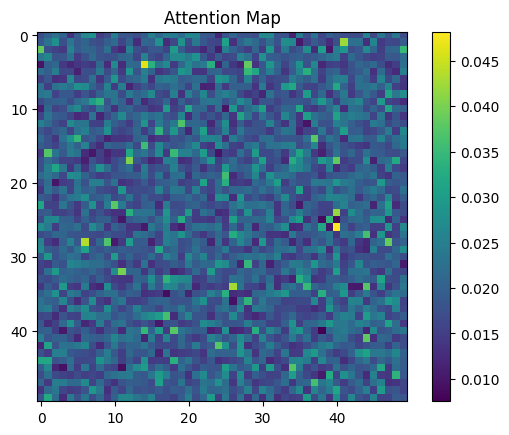

In [ ]:
tokens = torch.randn(1, 50, 128)
attn = nn.MultiheadAttention(128, 4, batch_first=True)

out, weights = attn(tokens, tokens, tokens)

plt.imshow(weights[0].detach(), cmap="viridis")
plt.title("Attention Map")
plt.colorbar()

###   Text encoder tower for SigLIP

In [ ]:
class TextEncoder(nn.Module):
    def __init__(self, vocab=1000, dim=256, proj_dim=128):
        super().__init__()

        self.emb = nn.Embedding(vocab, dim)

        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=dim,
                nhead=8,
                dim_feedforward=dim * 4,
                batch_first=True
            ),
            num_layers=4
        )

        # ✅ Projection head
        self.proj = nn.Linear(dim, proj_dim)

    def forward(self, tokens):
        x = self.emb(tokens)
        x = self.encoder(x)
        x = x.mean(dim=1)
        x = self.proj(x)                       # (B, 128)
        x = F.normalize(x, dim=-1)
        return x


In [ ]:
vit = ViTEncoder()
txt_enc = TextEncoder()


###   Generate image and text embeddings

In [ ]:
tokens = torch.randint(0, 1000, (1, 8))   # ✅ LongTensor

img_emb = vit(img.unsqueeze(0))     # (1, 128)
txt_emb = txt_enc(tokens)           # (1, 128)

sim = img_emb @ txt_emb.T           # ✅ WORKS


###   Compute pairwise SigLIP similarity matrix

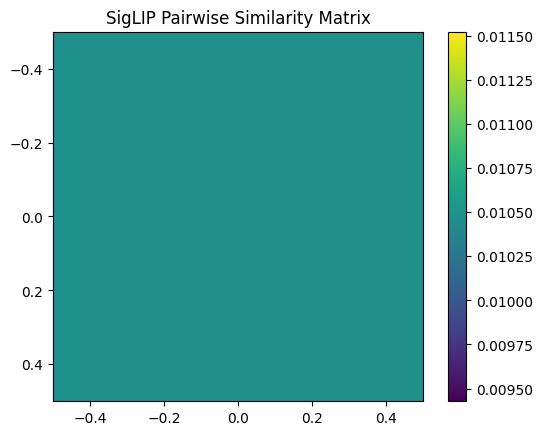

In [ ]:
sim = img_emb @ txt_emb.T
sig = torch.sigmoid(sim)

plt.imshow(sim.detach(), cmap="viridis")
plt.title("SigLIP Pairwise Similarity Matrix")
plt.colorbar()
plt.show()


###   Define SigLIP sigmoid loss

In [ ]:
def siglip_loss(img_emb, txt_emb):
    logits = img_emb @ txt_emb.T   # pairwise similarity matrix
    labels = torch.eye(logits.size(0)).to(logits.device)  # positives on diagonal
    loss = F.binary_cross_entropy_with_logits(logits, labels)
    return loss


###   Training loop optimizing vision-text alignment

In [ ]:

vit = ViTEncoder()
txt_enc = TextEncoder()

opt = torch.optim.Adam(list(vit.parameters()) + list(txt_enc.parameters()), lr=3e-4)

for epoch in range(2):
    for i, (imgs, labels) in enumerate(loader):
        tokens = torch.randint(0, 1000, (imgs.size(0), 10))

        img_emb = vit(imgs)
        txt_emb = txt_enc(tokens)

        img_emb = F.normalize(img_emb, dim=-1)
        txt_emb = F.normalize(txt_emb, dim=-1)
        loss = siglip_loss(img_emb, txt_emb)


        opt.zero_grad()
        loss.backward()
        opt.step()

        if i % 20 == 0:
            print(f"Epoch {epoch} Step {i} Loss:", loss.item())


Epoch 0 Step 0 Loss: 0.7230225205421448
Epoch 0 Step 20 Loss: 0.4397036135196686
Epoch 0 Step 40 Loss: 0.4385366439819336
Epoch 0 Step 60 Loss: 0.438399076461792
Epoch 0 Step 80 Loss: 0.43839481472969055
Epoch 0 Step 100 Loss: 0.4383784532546997
Epoch 0 Step 120 Loss: 0.43836545944213867
Epoch 0 Step 140 Loss: 0.4383724331855774
Epoch 0 Step 160 Loss: 0.43840882182121277
Epoch 0 Step 180 Loss: 0.4383690059185028
Epoch 0 Step 200 Loss: 0.4383588433265686
Epoch 0 Step 220 Loss: 0.43836167454719543
Epoch 0 Step 240 Loss: 0.4383656680583954
Epoch 0 Step 260 Loss: 0.438368022441864
Epoch 0 Step 280 Loss: 0.4383675456047058
Epoch 0 Step 300 Loss: 0.43835997581481934
Epoch 0 Step 320 Loss: 0.43834590911865234
Epoch 0 Step 340 Loss: 0.438345730304718
Epoch 0 Step 360 Loss: 0.43834975361824036
Epoch 0 Step 380 Loss: 0.43834376335144043
Epoch 0 Step 400 Loss: 0.43833649158477783
Epoch 0 Step 420 Loss: 0.43833211064338684
Epoch 0 Step 440 Loss: 0.4383361041545868
Epoch 0 Step 460 Loss: 0.43834877

KeyboardInterrupt: 

###   Final testing and retrieval demo

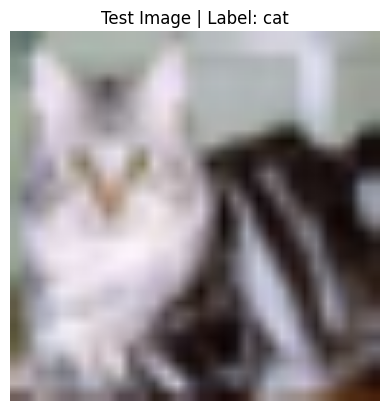


--- SIMILARITY SCORES ---
This is an image of a airplane           → 0.0218
This is an image of a automobile         → 0.0404
This is an image of a bird               → -0.0330
This is an image of a cat                → 0.0717
This is an image of a deer               → 0.1992
This is an image of a dog                → 0.0336
This is an image of a frog               → -0.0130
This is an image of a horse              → -0.0121
This is an image of a ship               → 0.1383
This is an image of a truck              → -0.0997

 BEST MATCH: This is an image of a deer


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
import random

# Load dataset
transform = T.Compose([T.Resize((224,224)), T.ToTensor()])
dataset = CIFAR10(root="./data", train=True, download=True, transform=transform)

# Define Patch Embedding
class PatchEmbed(nn.Module):
    def __init__(self, patch=16, dim=128):
        super().__init__()
        self.proj = nn.Conv2d(3, dim, patch, patch)
    def forward(self, x):
        x = self.proj(x)
        return x.flatten(2).transpose(1,2)

patch = PatchEmbed()

# Multi-Head Attention
attn = nn.MultiheadAttention(128, 4, batch_first=True)

# Pick random test image
idx = random.randint(0, len(dataset)-1)
test_img, test_label = dataset[idx]

# Show image
plt.imshow(test_img.permute(1,2,0))
plt.title(f"Test Image | Label: {dataset.classes[test_label]}")
plt.axis("off")
plt.show()

# Encode image
test_img = test_img.unsqueeze(0)
patch_tokens = patch(test_img)

# Positional Encoding
pos = nn.Parameter(torch.randn(1, patch_tokens.shape[1], patch_tokens.shape[2]))
pos_tokens = patch_tokens + pos

# Attention Forward Pass
attn_out, _ = attn(pos_tokens, pos_tokens, pos_tokens)
img_emb = attn_out.mean(dim=1)

# Create caption candidates
class_names = dataset.classes
text_candidates = [f"This is an image of a {c}" for c in class_names]

# Fake text embeddings (demo mode)
text_embeds = torch.randn(len(text_candidates), img_emb.shape[1])

# Similarity scores
scores = F.cosine_similarity(img_emb, text_embeds)

print("\n--- SIMILARITY SCORES ---")
for i, txt in enumerate(text_candidates):
    print(f"{txt:40s} → {scores[i].item():.4f}")

# Best match
best_idx = scores.argmax().item()
print("\n BEST MATCH:", text_candidates[best_idx])
